# When will the United Kingdom be Fully Vaccinated Against Covid-19?

**Author:** Jack Roberts, The Alan Turing Institute, [@jack89roberts](https://github.com/jack89roberts)

The Covid-19 pandemic has caused catastrophic losses and changes to life worldwide since the [first reported cases](https://www.who.int/news/item/29-06-2020-covidtimeline) in December 2019. A year later, in December 2020, Covid-19 vaccines began to be approved for general public use in countries worldwide, after an unprecedented speed and scale of development and clinical trials (for a process that [typically take closer to a decade](https://www.weforum.org/agenda/2020/06/vaccine-development-barriers-coronavirus/) to complete). Vaccines have therefore emerged as the shining light at the end of the tunnel that we all hope will lead to the end of the days of lockdown measures and hospitals filled to capacity.

So the question on the tip of our tongues in 2021 has been "when will I, my family, my country and the world be vaccinated against Covid-19?" In this data story we'll be focusing on the country-level question, with the objective of estimating when the adult population in the United Kingdom (UK) will be fully vaccinated against Covid-19. We'll collect data on the progress of the UK's vaccination programme so far, and then explore several approaches for forecasting how this might continue in the future.


**A brief introduction to vaccinations in the UK:**  The Pfizer/BioNTech vaccine, which uses new [mRNA vaccine technology](https://www.pfizer.co.uk/behind-science-what-mrna-vaccine), was given emergency approval on [2nd December 2020](https://www.gov.uk/government/publications/regulatory-approval-of-pfizer-biontech-vaccine-for-covid-19), with the first dose being administered to [91-year-old Margaret Keenan on 8th December](https://www.bbc.co.uk/news/uk-55227325). Since that date vaccines have continued to be rolled out in an increasing number of locations nationwide, including GP surgeries, hospitals, pharmacies and dedicated vaccination centres. The Oxford/AstraZeneca vaccine, [based on more traditional vaccine technology](https://vk.ovg.ox.ac.uk/vk/covid-19-vaccines), began to be administered around a month later [on 4th January](https://news.sky.com/story/covid-19-oxford-astrazeneca-vaccine-administered-to-first-people-in-uk-since-approval-12178858), and the Moderna mRNA vaccine more recently on [7th April 2021](https://www.bbc.co.uk/news/uk-wales-56657038). All three vaccines require two doses, typically spaced between one and three months apart. [Priority for vaccination](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf) is given to those at highest risk from Covid-19, namely healthcare workers, the elderly, and clinically vulnerable people. We expand on the details of the vaccination programme throughout this data story.

_Note that the story is written based on the status of the vaccination programme on 4th May 2021._


## Setup

For this analysis we'll be using the [requests](https://docs.python-requests.org/en/master/) and [json](https://docs.python.org/3/library/json.html) libraries for interacting with data from the internet, [numpy](https://numpy.org/), [pandas](https://pandas.pydata.org/) and [datetime](https://docs.python.org/3/library/datetime.html) for manipulating and analysing data and dates, and [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) for visualising data. In the cell below we also configure some of the defaults for the style of matplotlib figures, in particular increasing the font size.

In [1]:
# Get data from the internet
import requests
import json

# Analyse data and dates
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualisations
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.style.use("seaborn-notebook")
fontsize = 14
plt.rc("font", size=fontsize)
plt.rc("axes", titlesize=fontsize)
plt.rc("axes", labelsize=fontsize)
plt.rc("xtick", labelsize=fontsize)
plt.rc("ytick", labelsize=fontsize)
plt.rc("legend", fontsize=fontsize)
width = 12
height = 5
figsize = (width, height)
%matplotlib inline

## Getting the Data

The government has developed a Coronavirus dashboard which is updated daily with key statistics including the number of Covid-19 tests, cases, hospitalisations, deaths and vaccinations. You can view the dashboard here: https://coronavirus.data.gov.uk/

All of the source data can be downloaded, for example as a spreadsheet, by clicking the "download" button under each table or graph. Even better for our purposes is that the dashboard has an "Application Programming Interface" (API), which we can use to extract precisely the data we're interested in programmatically for this notebook!

The documentation for the API is found under the ["Developer's Guide" section](https://coronavirus.data.gov.uk/details/developers-guide) of the dashboard, which describes the various parameters that are available and how they should be configured. In particular, there are Python examples which show us how to structure a data query. There are three main steps, as follows:

**Step 1:** Defining the geographical region we are interested in. Some of the data is available regionally as well as nationally. The number of positive cases, for example, is available both for the UK as a whole but also down to "local authority" level (local council areas, of which there are over 300 in England alone). It's possible to get vaccine data for each of the four nations in the UK separately, but for this story we will consider the UK as a whole.

In the API, to define that we wish to retrieve summary data for the whole UK we must set the `areaType` parameter to be the value "overview", as follows:

In [2]:
filters = "areaType=overview"

**Step 2:** Defining which data we wish to retrieve. To explore the status of the vaccination programme we would like to know the number of new first and second vaccine doses administered on each day, and the overall (cumulative) total of first and second doses administered up to and including each day.

In the API these fields are given long names like `newPeopleVaccinatedFirstDoseByPublishDate`. Finding the correct names for the data you're interested can be a bit tricky. Most are listed in the documentation but not all - the vaccination data has been added fairly recently and isn't documented, for example. Usually the field names for the API match the column names in files downloaded from the website, so you can do some super sleuthing and find them that way if you'd like to try an analysis with different data!

As the names are long, the API helpfully let's us rename them to something more convenient using the dictionary format seen below. We'll call the cumulative totals `cumFirst` and `cumSecond`, and the new doses each day `newFirst` and `newSecond`. Finally, to pass this dictionary to the API it must be converted into a string without any spaces, which we achieve using the `json.dumps` function.

In [3]:
# define which data columns we wish to retrieve, and what to call them
structure = {
    "date": "date",
    "newFirst": "newPeopleVaccinatedFirstDoseByPublishDate",
    "cumFirst": "cumPeopleVaccinatedFirstDoseByPublishDate",
    "newSecond": "newPeopleVaccinatedSecondDoseByPublishDate",
    "cumSecond": "cumPeopleVaccinatedSecondDoseByPublishDate",
}

# convert the dictionary into a string without spaces (using the separators argument)
structure = json.dumps(structure, separators=(",", ":"))

**Step 3:** Submitting the API query. We can now package our parameters up into the structure required by the API, and  send our query using the `requests.get` function. If the query is successful we should see a status code of 200 ([as per the convention for request status codes](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status#successful_responses)). If not it should also come back with a useful error message to diagnose the problem with our query.

In [4]:
# query the API for the data
ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

api_params = {"filters": filters, "structure": structure}
response = requests.get(ENDPOINT, params=api_params, timeout=10)

if response.status_code != 200:
    request_failed = True
    print(f"Request failed: { response.text }")
else:
    request_failed = False

Our query was successful, but where is the data? We can convert the data the request contains into a Python function using the `.json()` method on the response, and then look at what fields are contained in the data (the keys of the dictionary):

In [5]:
if request_failed:
    # load previously saved data if API request failed
    with open("20210513_data.json") as f:
        j = json.load(f)
else:
    j = response.json()

print(j.keys())

dict_keys(['length', 'maxPageLimit', 'totalRecords', 'data', 'requestPayload', 'pagination'])


This doesn't look like the vaccination data we're expecting yet. The response also includes metadata about our query, in particular whether we queried too much data to return in one go. If the "length" of our query was larger than the  "maxPageLimit" we'd have to split our query into multiple queries.

In [6]:
print(j["length"], j["maxPageLimit"])

123 2500


In this case we are a long way under the limit so we should have all the data. To find it we can have a look at one of the elements in the "data" list:

In [7]:
print(j["data"][0])

{'date': '2021-05-12', 'newFirst': 184210, 'cumFirst': 35906671, 'newSecond': 452437, 'cumSecond': 18890969}


Each element of the "data" list contains the vaccination data for one day. To make it easier to analyse the data we can convert it to a pandas data frame, using the date as the unique index for the rows (as we have one row for each day). We also take care to properly convert the date string representations into actual Python datetimes, so we can benefit from pandas' features for processing time series data. We also convert the numbers into units of 1 million to make them easier to read in figures and tables later.

In [8]:
df = pd.DataFrame(j["data"])

# use the "date" column to index our data
df.set_index("date", inplace=True)
# convert the date text strings into Python datetimes
df.index = pd.to_datetime(df.index)
# sort the data from oldest to newest
df.sort_index(inplace=True)

# convert all totals to millions
df = df / 1e6

df.tail()

,newFirst,cumFirst,newSecond,cumSecond
date,,,,
2021-05-08,0.169027,35.371669,0.438837,17.669379
2021-05-09,0.100626,35.472295,0.187171,17.856550
2021-05-10,0.115053,35.587348,0.231835,18.088385
2021-05-11,0.135113,35.722461,0.350147,18.438532
2021-05-12,0.184210,35.906671,0.452437,18.890969


Later on, it will also be helpful to have data on the total number of doses given, i.e. the number of first doses plus the number of second doses. Pandas let's us quickly create new columns for these values, as follows:

In [9]:
df["newTot"] = df["newFirst"] + df["newSecond"]
df["cumTot"] = df["cumFirst"] + df["cumSecond"]

Our query above gets all the data up to the current date. To ensure re-running the notebook reproduces the same results from the time of writing only data up to 4th May should be included, which is done using the `run_as_date` variable below. If you'd like to see the latest results instead you can change the value to today's date.

In [10]:
# To reproduce the results at the time of publishing the story set the date below to
# 4th May 2021 (run_as_date = datetime(2021, 5, 4)), or use today's date to update
# the results with the latest available data (run_as_date = datetime.now()).
run_as_date = datetime(2021, 5, 4)

# Latest data at time of publishing (vs. initial time of writing as above)
# Used to compare forecasts with actual data at the end of the story
publish_date = datetime(2021, 5, 12)
publish_date_data = df.loc[publish_date]

# filter the data to only include dates up to the run_as_date
df = df[df.index < run_as_date]

## Vaccines So Far

Now we have the data we need to start forecasting the future of the vaccination programme, but before we jump in it's always a good idea to explore the historical data first. Let's have a look at the first row of our data (the earliest date we have data for):

In [11]:
df.iloc[0]

newFirst          NaN
cumFirst     2.286572
newSecond         NaN
cumSecond    0.391399
newTot            NaN
cumTot       2.677971
Name: 2021-01-10 00:00:00, dtype: float64

The last row of our data (the last date we have data for):

In [13]:
df.iloc[-1]

newFirst      0.072600
cumFirst     34.667904
newSecond     0.127499
cumSecond    15.630007
newTot        0.200099
cumTot       50.297911
Name: 2021-05-03 00:00:00, dtype: float64

And finally the mean (average) number of doses administered per day:

In [12]:
df["newFirst"].mean(), df["newSecond"].mean()

(0.2865604601769912, 0.13485493805309734)

Although the first Covid-19 vaccine in the UK (outside of clinical trials) was administered on [8th December 2020](https://www.bbc.co.uk/news/uk-55227325), the daily data that we have starts on 10th January 2021, by which time 2.29 million first doses and 0.39 million second doses had been given. Since that date a mean (average) of 0.29 million (290,000) first doses and 0.13 million (130,000)  second doses have been administered per day. As of 3rd May 2021, a total of 34.7 million people have been vaccinated with a first dose and 15.6 million with a second dose, which we can see by looking at the last row of the data.

To make sense of these numbers we are missing one more piece of data - how many people are there to vaccinate? We can find this in the [government's vaccine delivery plan](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/951928/uk-covid-19-vaccines-delivery-plan-final.pdf). The plan specifies that the UK adult population (children are not currently being vaccinated) is approximately 53 million people, as well giving the sub-totals for the nine priority groups who will receive vaccines first. Government targets typically focus on three goals - vaccinating the 15 million people in priority groups 1-4 (the over 70s, care home residents, and health & social care workers), the 32 million people in the groups 1-9 (additionally including over 50s and the clinically vulnerable), and the whole adult population. 

Comparing to the numbers above, we can see that the number of people vaccinated so far exceeds the population of groups 1-9 for first doses, and of groups 1-4 for second doses. However, this doesn't mean _everyone_ in those groups has been vaccinated. Although take up rates of the vaccine in the UK are high, there is regional variation in the speed of the rollout and take up rates are lower in certain sub-groups, such as for [ethnic minorities, poorer areas](https://www.bbc.co.uk/news/health-55274833), and [care home staff](https://www.theguardian.com/society/2021/apr/14/care-home-staff-could-be-required-to-have-a-covid-vaccination-says-matt-hancock). The population in each priority group is also estimated as the groups can be overlapping. For example, a clinically vulnerable, 50 year-old social care worker meets the criteria for priority groups 2, 6 and 9. Further statistics on take up rates can be found in [NHS England data](https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-vaccinations/).

Bearing all the above in mind, the priority group population totals are still helpful to give a rough estimate of progress through the vaccination programme so let's save them for future use:

In [14]:
# no. people to vaccinate in each priority group (in millions)
priority_totals = {"Groups 1-4": 15, "Groups 1-9": 32, "All Adults": 53}

It's helpful to visualise the data, so before continuing we will do a bit of work here to set up plotting functions we can re-use throughout our analysis. First let's define colours and labels to use for the data columns in all the figures we create. These are in the `col_format` dictionary below, which all our plotting functions can access.

Then we define a function `plot_column`, which uses the pandas `plot` function to plot a column from the dataset in our chosen style. It also includes options to display a weekly rolling average of the data, rather than the original raw data, calculated using the statement `df[column].rolling(window=7).mean()` below (where `window=7` means we calculate the average across 7 days). Finally, it will be helpful to distinguish between actual historical vaccine data, and estimates from the forecasts we create. If the `forecast_date` argument is defined the data after that date will be plotted with a dashed line instead of a solid line. The data after that date is selected using the statement `data[data.index >= forecast_date]`.

In [15]:
col_format = {
    "cumFirst": {"label": "1st", "color": "orange"},
    "cumSecond": {"label": "2nd", "color": "deepskyblue"},
    "cumTot": {"label": "Total", "color": "k"},
    "newFirst": {"label": "1st", "color": "orange"},
    "newSecond": {"label": "2nd", "color": "deepskyblue"},
    "newTot": {"label": "Total", "color": "k"},
}


def plot_column(
    df,
    column,
    ax,
    forecast_date=None,
    rolling=False,
    forecast_label="Forecast",
    **kwargs
):
    """
    Plot a column in a data frame, optionally calculating its rolling weekly
    average and distinguishing between actual and forecasted data.
    df - vaccination data frame
    column - column of df to plot
    ax - matplotlib axis to use for the plot
    forecast_date - plot data from this date with a dashed line
    rolling - plot rolling weekly average instead of raw data
    forecast_label - label given to forecast data in plot legend
    **kwargs - additional arguments passed to pandas plotting function
    """
    color = col_format[column]["color"]
    label = col_format[column]["label"]

    if rolling:
        data = df[column].rolling(window=7).mean()
        label = label + " (7d avg)"
    else:
        data = df[column]

    if forecast_date is None:
        data.plot(color=color, label=label, ax=ax, **kwargs)
    else:
        # plot actual data with solid line
        data[data.index <= forecast_date].plot(
            color=color, label=label, ax=ax, linestyle="-", linewidth=3, **kwargs
        )
        # plot forecast data with dashed line
        data[data.index >= forecast_date].plot(
            color=color,
            label=forecast_label + " " + label,
            ax=ax,
            linestyle="--",
            **kwargs
        )

As well as showing the number of doses, we'd like to show when the number of people vaccinated (with 1st or 2nd doses) exceeds the total of each priority sub-group. For each group, we can find the date this happened using the statement `df[df[column] >= (pop - tol)].index[0]`, where `pop` is the population of the sub-group, `column` is either `cumFirst` or `cumSecond` (depending on whether we want to calculate it for 1st or 2nd doses), and `tol` is a small value used to account for any rounding errors in the forecasts we do later.

The `annotate_group_completions` function below can then be used to add horizontal and vertical lines and text labels to a plot for those dates. As discussed earlier, we must remember that it's not true that everyone in the priority group will have been vaccinated by the dates we calculate here, rather they are general indicators of overall progress.


In [16]:
def annotate_group_completions(df, column, ax, text_offset=1.02, tol=1e-7):
    """
    Add text labels and lines indicating the dates the number of people
    vaccinated exceded the population of priority sub-groups.
    df - vaccination data frame
    column - column to add labels for, either cumFirst or cumSecond
    ax - matplotlib axix to add labels to
    text_offset - space between data point and text label
    tol - define group to be vaccinated if total vaccines is within tol of its population
    """
    label = col_format[column]["label"]
    max_col = df[column].max()

    for name, pop in priority_totals.items():
        if max_col >= (pop - tol):  # vaccines completed for this group
            complete_date = df[df[column] >= (pop - tol)].index[0]

            ax.hlines(pop, 0, complete_date, color="k", linewidth=0.5)
            ax.vlines(complete_date, 0, pop, color="k", linewidth=0.5)
            ax.text(
                complete_date,
                pop * text_offset,
                f"{name}\n{label} Doses\n{complete_date.date()}",
                ha="center",
                size=12,
                fontweight="bold",
            )
            # extend x-axis if text label is near the end of the axis
            if df.index.max() - complete_date < timedelta(days=7):
                ax.set_xlim(df.index.min(), complete_date + timedelta(days=7))

Now we are almost there! The `plot_cumulative_doses` function below uses the two previous functions to construct a figure for the cumulative total of first and second doses:

In [17]:
def plot_cumulative_doses(
    df, forecast_date=None, figsize=figsize, title=None, forecast_label="Forecast"
):
    """
    Plot cumulative first and second doses, and the dates when
    the vaccination of prioriy groups completed.
    Optionally distinguish actual data and forecasted data. Data
    after forecast_date will be displayed with a dashed line.
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for col in ["cumFirst", "cumSecond"]:
        plot_column(
            df,
            col,
            ax,
            forecast_date=forecast_date,
            forecast_label=forecast_label,
        )
        annotate_group_completions(df, col, ax)

    # set axis limits, titles and legend
    ymin = 0
    ymax = df["cumFirst"].max() * 1.15
    ax.spines['top'].set_visible(False)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel("Number of Doses [millions]")
    ax.set_xlabel("")
    ax.legend(loc="upper left")
    if title is not None:
        ax.set_title(title, fontsize=18)

    # add a secondary y-axis showing the % of the population  vaccinated
    right_ax = ax.twinx()
    right_ax.spines['top'].set_visible(False)
    uk_pop = priority_totals["All Adults"]
    y_perc_min = 100 * ymin / uk_pop
    y_perc_max = 100 * ymax / uk_pop
    right_ax.set_ylim(y_perc_min, y_perc_max)
    right_ax.set_yticks(range(int(y_perc_min), min(int(y_perc_max), 110), 10))
    right_ax.set_ylabel("% Adults Vaccinated")

    return ax

The following figure shows the history of the total number of people vaccinated with first and second doses, and the dates when priority groups were vaccinated:

<AxesSubplot:title={'center':'UK Vaccinations up to 2021-05-03'}, ylabel='Number of Doses [millions]'>

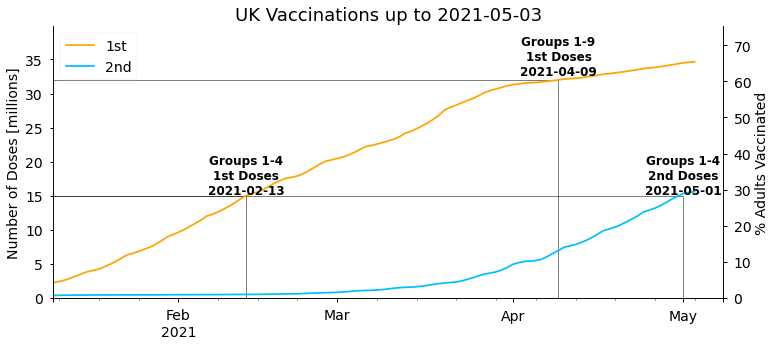

In [18]:
plot_cumulative_doses(df, title=f"UK Vaccinations up to {df.index.date.max()}")

As stated in [Boris Johnson's address to the nation on 4th January 2021](https://www.gov.uk/government/speeches/prime-ministers-address-to-the-nation-4-january-2021), the first target the government set was to offer the first dose of a vaccine to everyone in the top four priority groups by mid-February. As we can see above this target was met on 13th February. The [next target set by the government](https://www.gov.uk/government/speeches/prime-ministers-statement-on-coronavirus-covid-19-10-february-2021) was then to offer a first dose to the first nine priority groups (the over 50s) with a first dose by the end of April. This was somewhat pessimistic given the vaccination rates at the time, and was ultimately completed a couple of weeks earlier on 9th April. Overall, the start of the UK vaccination programme has been very successful and amongst the fastest in the world.

It's also interesting to look at the daily number of new doses each day, and this is particularly relevant for forecasting future doses. As there's quite a large variation in the day to day totals (more on this later) it's helpful to look at weekly rolling averages as well. We'll also display the combined total of 1st and 2nd doses administered on each day (`newTot`), as this gives the best representation of the overall vaccine supply and capacity to administer vaccines.

We can create a similar function to do this: 

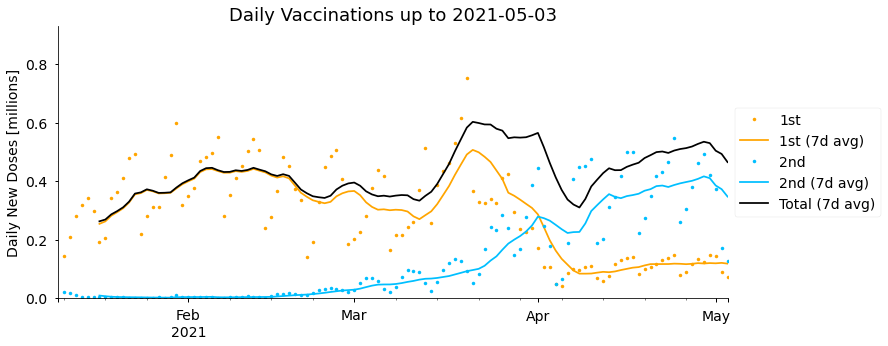

In [19]:
def plot_daily_doses(
    df,
    forecast_date=None,
    show_daily=True,
    show_rolling=True,
    figsize=figsize,
    title=None,
):
    """
    Plot daily first doses, second doses, the sum of 1st
    and 2nd doses, and their weekly rolling averages.
    """
    # figure properties
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    for col in ["newFirst", "newSecond", "newTot"]:
        if show_daily and col != "newTot":  # display daily data
            plot_column(df, col, ax, marker=".", linestyle="None")

        if show_rolling:  # display 7 day averages
            plot_column(df, col, ax, forecast_date=forecast_date, rolling=True)

    ax.set_ylim(0, df["newTot"].max() * 1.1)
    ax.set_xlabel("")
    ax.set_ylabel("Daily New Doses [millions]")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    if title is not None:
        ax.set_title(title, fontsize=18)


plot_daily_doses(df, title=f"Daily Vaccinations up to {df.index.date.max()}")

Between January and until early February the vaccine doses administered per day steadily increased from around 0.25 million to 0.45 million on average. After that date rates plateaued and temporarily fell, mostly due to challenges and [fluctuations in securing vaccine supplies](https://news.sky.com/story/covid-19-daily-drop-off-in-vaccinations-is-down-to-supply-fluctuations-but-will-pick-up-says-prof-jonathan-van-tam-12227465). Late March saw the highest rates, peaking at 0.6 million doses per day in the week starting 14th March, though this then fell again, particularly over the Easter weekend (2nd-5th April), before recovering more recently. Supply difficulties are currently [expected to continue in coming months](https://www.theguardian.com/politics/2021/apr/06/england-covid-vaccine-programme-could-slow-sharply-sage-warns). As well as fluctuations in the total, we can see that the number of second doses administered has been steadily increasing, and overtook the rate of new first doses in early April, with relatively few new first doses being given since then. More on this later.

If you look closely at the actual daily numbers of 1st and 2nd doses (the markers rather than the rolling average lines), it seems like they vary up and down with a period of 7 days. We can make this clearer by plotting the number of doses delivered on each weekday.

The day of the week for all the dates in our data can be determined using the pandas function `day_name`. Then we make use of the `boxplot` function in the `seaborn` plotting library to show the distribution in doses delivered on each weekday:

Text(0, 0.5, 'Daily Doses (1st + 2nd) [millions]')

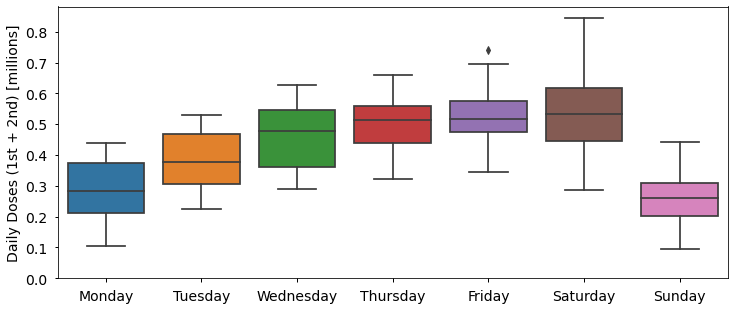

In [20]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=figsize)
sns.boxplot(
    x="weekday",
    y="newTot",
    data=df,
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.xlabel("")
plt.ylim([0, plt.ylim()[1]])
plt.ylabel("Daily Doses (1st + 2nd) [millions]")

More doses are administered Wednesday to Saturday than Sunday to Tuesday, with on average half as many (0.26 million) delivered on Sunday than on Saturday (0.53 million). Although I could not find an official explanation for this, one factor is likely related to the capacity and opening hours of vaccination centres and GP surgeries, which are more likely to be closed on Sundays for example. Other statistics have similar trends, such as [fewer Covid-19 deaths being recorded at weekends due to reporting delays](https://www.bbc.co.uk/news/health-52167016).

## When are Second Doses Being Given?

A high-profile decision announced by the UK Joint Committee on Vaccination and Immunisation (JCVI) [on the 30th December 2020](https://www.gov.uk/government/publications/priority-groups-for-coronavirus-covid-19-vaccination-advice-from-the-jcvi-30-december-2020/joint-committee-on-vaccination-and-immunisation-advice-on-priority-groups-for-covid-19-vaccination-30-december-2020), was to delay second doses by as long as possible, up to 12 weeks instead of the originally recommended 3-4 weeks. The decision was taken to be able to protect as many people as possible with a single dose of the vaccine within the first few months of the year, but [was fairly controversial at the time](https://www.bmj.com/content/372/bmj.n18) due to clinical trials using shorter gaps between doses.

The delay between first and second doses will be an important component in our forecasts, so let's calculate when second doses are actually being given in practice (more precisely than "up to 12 weeks"). We can estimate this by determining the number of days until the total number of second doses (`cumSecond`) matches the total number of first doses (`cumFirst`) on a given date.

The for loop below calculates the delay for all dates in the past, and then prints the most recent delay:

In [21]:
for date_2nd, row in df.sort_index(ascending=False).iterrows():
    if row["cumSecond"] >= df["cumFirst"].min():
        # find the last date where number of 1st doses is less than
        #  or equal to number of 2nd doses on current row
        date_1st = df[df["cumFirst"] <= row["cumSecond"]].index.max()
        # calculate how many days it was until 2nd doses were given
        delay = (date_2nd - date_1st).days
        df.loc[date_2nd, "delaySecond"] = delay
    else:
        break

avg_second_delay = df["delaySecond"][-1]
print(
    "1st doses from",
    (df.index[-1] - timedelta(days=avg_second_delay)).date(),
    "were completed",
    avg_second_delay,
    "days later, on",
    df.index[-1].date(),
)

1st doses from 2021-02-15 were completed 77.0 days later, on 2021-05-03


Currently, second doses are lagging first doses by 77 days, or around ten and a half weeks. In the history of the data so far, the delay has varied between 71 and 77 days:

In [22]:
df["delaySecond"].min(), df["delaySecond"].max()

(71.0, 77.0)

With the gap increasing from 72 to 75 days over the Easter weekend (2nd-5th April) where fewer doses (of any type) were administered than normal, and slowly drifting towards longer delays since then:

Text(0, 0.5, '2nd Dose Delay [days]')

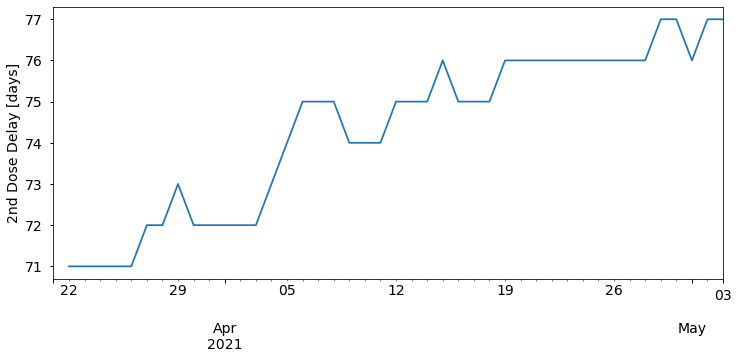

In [23]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df.loc[df.index >= datetime(2021, 3, 21), "delaySecond"].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("2nd Dose Delay [days]")

The second dose delay values we calculate here are averages for the whole country. In reality, the actual gap between doses for each individual will vary depending on the availability of appointments and vaccination strategy in their area. 

## Forecasting Future Vaccinations

Now we have a good idea about what's happened so far, but knowing that how can we forecast when the UK might fully vaccinate the adult population? At a high level, there will be two components to our forecasts: estimates for the total number of doses that will be administered on each future date, and of how those doses will be divided between first doses and second doses. We won't specify the exact form of our total daily doses estimation for now, except saying that it will be a function depending on two arguments - the date we want an estimate for, and the previous vaccination data. This general form will allow us to quickly try a few different forecasting approaches later.

For the second part (deciding which of the available vaccines will be given as first or second doses) we will make a number of assumptions that apply to all the forecasts we generate, as follows:
- Everyone is given two doses of a vaccine.
- Second doses are given `avg_second_delay` days after first doses (as calculated above). This means we expect the cumulative total of second doses today to match the cumulative total of first doses `avg_second_delay` days ago. Or equivalently, the number of new second doses required today is the difference between the current cumulative total of second doses and the cumulative total of first doses `avg_second_delay` days ago.
- Second doses are given priority over new first doses. New first doses will only be given if the total number of doses available on a given day is more than the number of people requiring a second dose.
- Once there is capacity to do so, second doses can be given sooner than `avg_second_delay` days later. [Current UK guidance](https://www.gov.uk/government/publications/priority-groups-for-coronavirus-covid-19-vaccination-advice-from-the-jcvi-30-december-2020/joint-committee-on-vaccination-and-immunisation-advice-on-priority-groups-for-covid-19-vaccination-30-december-2020) is that second doses of the Pfizer vaccine can be administered after 3 weeks, or after 4 weeks for the AstraZeneca vaccine, and up to 12 weeks later for both.
- 100% of the UK adult population will be vaccinated.

These assumptions generally seem reasonable, but there are limitations with all of them. It's likely that [booster doses of Covid-19 vaccines will be needed](https://www.bmj.com/content/372/bmj.n664), so ultimately people may receive more than two doses (so we're predicting only the completion of the first phase of the UK vaccination programme). Alternatively, single-dose vaccines such as the [Johnson & Johnson vaccine](https://www.bbc.co.uk/news/world-us-canada-56226979) may start to be administered. New vaccine types coming online may also invalidate our third assumption above, as doses of a new vaccine can only be given as first doses initially - they can't be prioritised for second doses straight away like other vaccines (unless people begin to be given two doses of different vaccine types). Although it seems reasonable to give second doses earlier once there is spare capacity to do so, we don't know whether this will be the case and it may be that spare capacity is re-directed elsewhere. We've also seen that the delay between doses has varied between 71 and 77 days so far, but we initially keep it fixed at the most recent value of 77 days. Finally, vaccine [uptake in the over 50s has been close to 95%](https://www.gov.uk/government/speeches/statement-on-vaccination-progress-and-new-variants) overall, but it's not 100% and has been much lower [in certain sub-groups](https://www.bbc.co.uk/news/health-55274833) as discussed earlier. It's also possible uptake will decrease further in younger age groups. We should keep all these limitations in mind when interpreting our results.

The `forecast_vaccines` function below encodes everything described above. We give the vaccination data so far (as the input `df`), add new rows for future dates up to a specified `end_date`, determine how many doses will be administered on each date using a function `doses_fn` (that we haven't defined yet), and distributes those doses according to our assumptions. In many places the `timedelta` function from the python `datetime` library is used to get data from a number of days before the forecast date.


In [24]:
def forecast_vaccines(
    df,
    avg_second_delay,
    doses_fn,
    uk_pop=priority_totals["All Adults"],
    end_date=datetime(2021, 12, 1),
    min_second_delay=28,
):
    """
    Forecast future vaccine doses.

    df: DataFrame of actual vaccine data.
    avg_second_delay: Days after 1st dose that 2nd doses will be given.
    doses_fn: Function to calculate number of doses administered each
    day. Takes 2 arguments - df and a date.
    uk_pop: Total population to be vaccinated.
    end_date: Forecast until this date.
    min_second_delay: If there is spare capacity, allow second doses to
    be given earlier than avg_second_delay, down to this number of days.
    """
    # extend our time series index to the future
    first_data = df.index.min()
    last_data = df.index.max()
    if end_date < last_data:
        raise ValueError(
            f"end_date ({end_date}) should be after the last date in df {last_data}"
        )
    future_dates = pd.date_range(last_data, end_date, closed="right")
    df = df.append(pd.DataFrame(index=future_dates))
    df.sort_index(inplace=True)

    for d in future_dates:
        if d - timedelta(days=avg_second_delay) < first_data:
            # no 1st dose data avg_second_delay ago, assume no 2nd doses required
            pending_2nd_doses = 0
        else:
            # 2nd doses needed is difference between 2nd doses so far and 1st
            # doses avg_second_delay days ago (who now require 2nd dose)
            dose2_req = df.loc[d - timedelta(days=avg_second_delay), "cumFirst"]
            dose2_sofar = df.loc[d - timedelta(days=1), "cumSecond"]
            pending_2nd_doses = max([0, dose2_req - dose2_sofar])

        # use forecasting function to determine number of doses available today
        total_doses_today = doses_fn(df, d)

        # don't vaccinate more than the total population (with 2 doses)
        if total_doses_today + df.loc[d - timedelta(days=1), "cumTot"] > 2 * uk_pop:
            total_doses_today = 2 * uk_pop - df.loc[d - timedelta(days=1), "cumTot"]

        # give all 2nd doses required (up to limit of total doses available)
        dose2_today = min(pending_2nd_doses, total_doses_today)

        # remaining vaccines given as new 1st doses
        dose1_remaining = uk_pop - df.loc[d - timedelta(days=1), "cumFirst"]
        dose1_today = min(total_doses_today - dose2_today, dose1_remaining)

        # if there are spare doses, try giving 2nd doses earlier than usual
        if dose1_today + dose2_today < total_doses_today:
            dose2_poss_early = df.loc[d - timedelta(days=min_second_delay), "cumFirst"]
            dose2_today = min(total_doses_today - dose1_today, dose2_poss_early)

        # save today's values
        df.loc[d, "newSecond"] = dose2_today
        df.loc[d, "cumSecond"] = (
            df.loc[d - timedelta(days=1), "cumSecond"] + dose2_today
        )
        df.loc[d, "newFirst"] = dose1_today
        df.loc[d, "cumFirst"] = df.loc[d - timedelta(days=1), "cumFirst"] + dose1_today
        df.loc[d, "newTot"] = dose1_today + dose2_today
        df.loc[d, "cumTot"] = df.loc[d, "cumFirst"] + df.loc[d, "cumSecond"]

    return df

The final piece of estimating the number of doses that will be available in the future is also where we have the least certainty. The scale and speed of the Covid-19 vaccine roll-out worldwide is unprecedented and there have been challenges, such as with [lower production than expected in supply chains](https://www.ft.com/content/df5020f4-461e-443e-8d55-f3234690d049), and other delays such as the [roll-out of the AstraZeneca vaccine being paused in some countries](https://www.sciencemag.org/news/2021/03/european-countries-resume-use-astrazenecas-covid-19-vaccine-hoping-pause-has-not-dented) to investigate side-effects.

Given these circumstances it's possible future vaccine supply in the UK could be quite different to past supply. But as a starting point let's consider a simpler question - when will the UK population be vaccinated if doses continue to be given at the same rate as the last two weeks? In the last two weeks, vaccines have been given at a rate of:

In [25]:
n_days = 14
mean_doses_this_week = df["newTot"].tail(n_days).mean()
print(
    "Between",
    df.index[-n_days].date(),
    "and",
    df.index[-1].date(),
    f"there was a mean of {mean_doses_this_week:.2f}",
    "million doses given per day.",
)

Between 2021-04-20 and 2021-05-03 there was a mean of 0.49 million doses given per day.


Now all we need to run our forecast is to create the function to calculate how many doses are available each day. In this case it can be a simple function (`const_doses` below) that always returns the 0.49 million average daily doses calculated above. Even though we don't use them here, the function must have two inputs (`df` and `date`) to be compatible with our general `forecast_vaccines` function created above. Let's wrap all this into a function `forecast_const` we can easily use to run forecasts with other constant daily dose totals, then run it on our last week average:

In [26]:
def forecast_const(
    df,
    avg_second_delay,
    daily_doses,
    uk_pop=priority_totals["All Adults"],
    end_date=datetime(2021, 10, 1),
    min_second_delay=28,
):
    """
    Forecast vaccines assumming 'daily_doses' doses are given per day.
    """

    def const_doses(df, date):
        return daily_doses

    df_forecast = forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=const_doses,
        uk_pop=uk_pop,
        end_date=end_date,
        min_second_delay=min_second_delay,
    )

    return df_forecast


df_forecast = forecast_const(df, avg_second_delay, mean_doses_this_week)

We can re-use our plotting functions to examine our forecast. Let's start with the daily number of 1st and 2nd doses given per day:

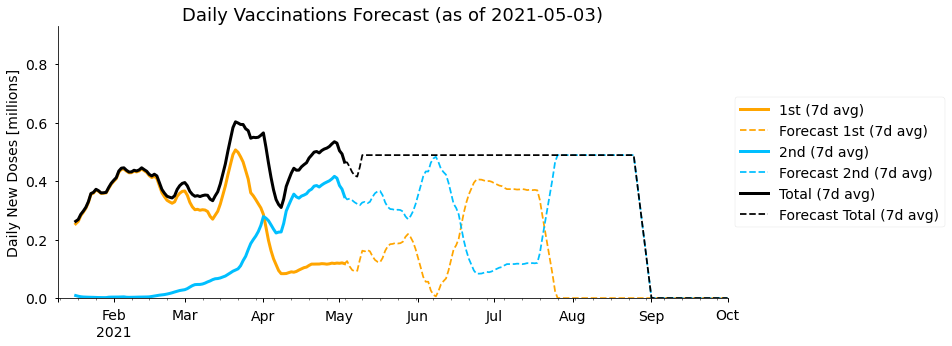

In [27]:
last_data = df.index.max()

plot_daily_doses(
    df_forecast,
    forecast_date=last_data,
    show_daily=False,
    title=f"Daily Vaccinations Forecast (as of {df.index.date.max()})",
)

As expected, the total number of (1st + 2nd) doses given per day remains constant throughout our simple forecast. In the 1st and 2nd doses we see an interesting pattern where every couple of months the doses being administered swap between being mostly first doses or mostly second doses. In fact, the period over which this happens is approximately the 77 day gap between first and second doses we have assumed. At the start of the year (almost) the whole vaccine capacity was dedicated to giving new first doses, and then starting from late March all those people must be given second doses, meaning there is little spare capacity for new first doses. Our forecast predicts we will need to go through this cycle two times to vaccinate the whole population with two doses.

Now let's look at when we predict each sub-group of the population will be vaccinated:

<AxesSubplot:title={'center':'UK Vaccination Forecast (as of 2021-05-03)'}, ylabel='Number of Doses [millions]'>

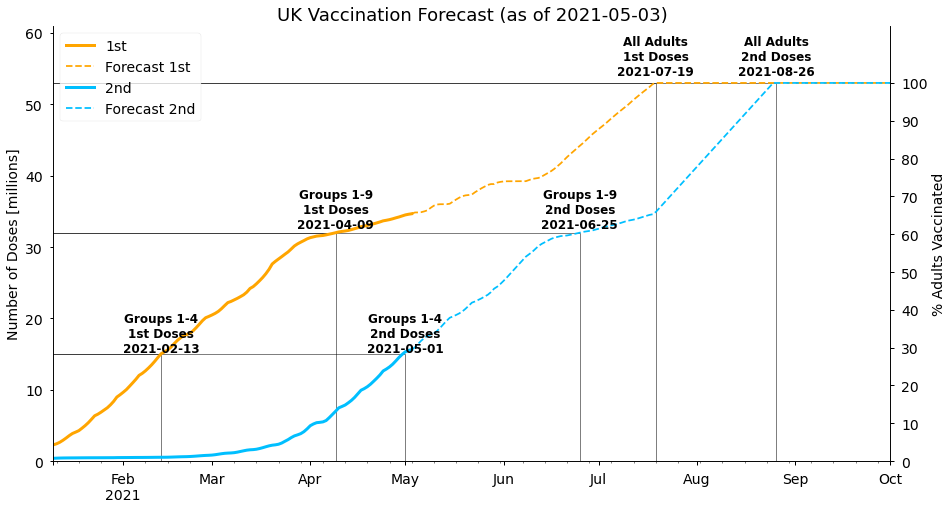

In [28]:
plot_cumulative_doses(
    df_forecast,
    forecast_date=last_data,
    figsize=(15, 8),
    title=f"UK Vaccination Forecast (as of {df.index.date.max()})",
)

The current phase of mostly second dose vaccines being given leads to 32 million people (the population of groups 1-9) being fully vaccinated by late June in our forecast. The rest of the adult population is given a first dose of the vaccine by 19th July, and then is fully vaccinated on 26th August. Note that this gap is only 38 days (less than the 77 days between doses we use initially), as we allow second doses to be given earlier once there is spare capacity to do so.

## Alternative Forecasts

Our forecast assumed doses will continue to be given at the rate from the the last two weeks, but looking back at the data we can see that this is higher than at most other times so far this year. Although it's possible the number of daily doses increases further in the future, we could consider that to be fairly optimistic. It may seem unlikely that vaccination rates fall to the levels seen at the start of the year, but there are reasons this could be the case. In particular, near the end of the vaccination programme demand may be lower in the remaining population, which [was the case in Israel](https://time.com/5947967/israel-covid-vaccine-rollout/) earlier this year for example. So what if we ask a more pessimistic question - when will the population be vaccinated with two doses if vaccines are administered at the same rate as the whole year so far? Or, even better, what is the range of likely completion dates? 

To answer this, we'll create a new `doses_fn` (`rnd_doses` below) where the total number of doses given on any date in the future is the same as the number given on a day in the past, with that day selected randomly. We also limit the date in the past to have the same weekday as the forecast date, to take into account the differences during the week seen earlier (with more doses given Thursday-Saturday). Because the number of doses is chosen randomly, each time the forecast is run we'll get a different result. By running the forecast many times we can get an estimate of the uncertainty in the completion dates.

This is done using `forecast_rnd` function below, which returns a list of 200 forecasts:

In [29]:
def forecast_rnd(
    df,
    avg_second_delay,
    uk_pop=priority_totals["All Adults"],
    end_date=datetime(2021, 10, 1),
    min_second_delay=28,
    rng=np.random.default_rng(seed=123),
    n_forecasts=100,
):
    """
    Run n_forecasts random forecasts, using the random number
    generator rng to randomly choose the number of doses today
    to be the same as a date in the past on the same weekday.
    """

    def rnd_doses(df, date):
        doses = rng.choice(
            df.loc[df.index.dayofweek == date.dayofweek, "newTot"].dropna()
        )
        return doses

    forecasts = [
        forecast_vaccines(
            df,
            avg_second_delay,
            doses_fn=rnd_doses,
            uk_pop=uk_pop,
            end_date=end_date,
            min_second_delay=min_second_delay,
        )
        for _ in range(n_forecasts)
    ]

    return forecasts


n_forecasts = 200
rnd_forecasts = forecast_rnd(df, avg_second_delay, n_forecasts=n_forecasts)

If we plot the number of daily doses in each of the 200 forecasts we get a spread of values centred around the average rate for the year, as expected:

Text(0.5, 1.0, 'Daily New Doses (7 day Average)')

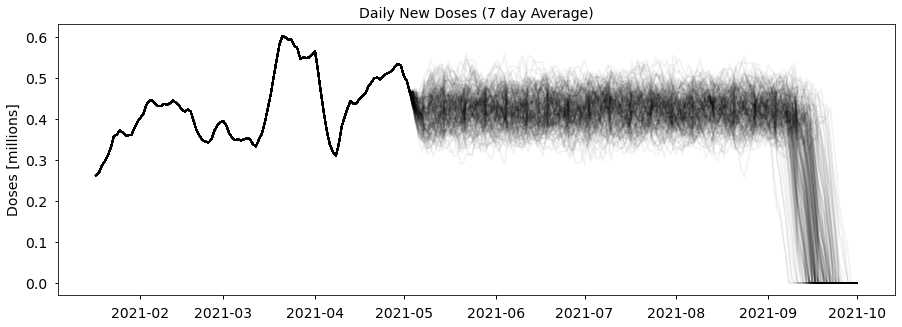

In [30]:
plt.figure(figsize=(15, 5))
for fcast in rnd_forecasts:
    plt.plot(
        fcast["newTot"].rolling(window=7).mean(), alpha=10 / n_forecasts, color="k"
    )

plt.ylabel("Doses [millions]")
plt.title("Daily New Doses (7 day Average)")

Rather than plotting each of the 200 individual forecasts, let's calculate 50% (median), 2.5% and 97.5% quantiles of the forecasts, specifically of the cumulative total of first and second doses. 95% of the forecast values lie between the 2.5% and 97.5% quantiles, so we can be confident the future data will be in that range (but only under our assumption that vaccines are given at the same rate as the year so far). 

To do that we can combine all the data for one column into a single data frame with the `pd.concat` function, then calculate the quantiles with the pandas `quantiles` function:

In [31]:
quantiles = [0.025, 0.5, 0.975]
q_forecasts = {}

for i, col in enumerate(["cumFirst", "cumSecond"]):
    rnd_col = pd.concat(
        [fcast[col].rename(f"forecast{i}") for fcast in rnd_forecasts],
        axis=1,
        names=[0, 1],
    )
    q_forecasts[col] = rnd_col.quantile(quantiles, axis=1)

Now let's plot the median of our forecasts, create a shaded range between the 2.5% and 97.5% quantiles to show the uncertainty (with the matplotlib function `fill_between`), and also display our original "last week" forecast to compare:

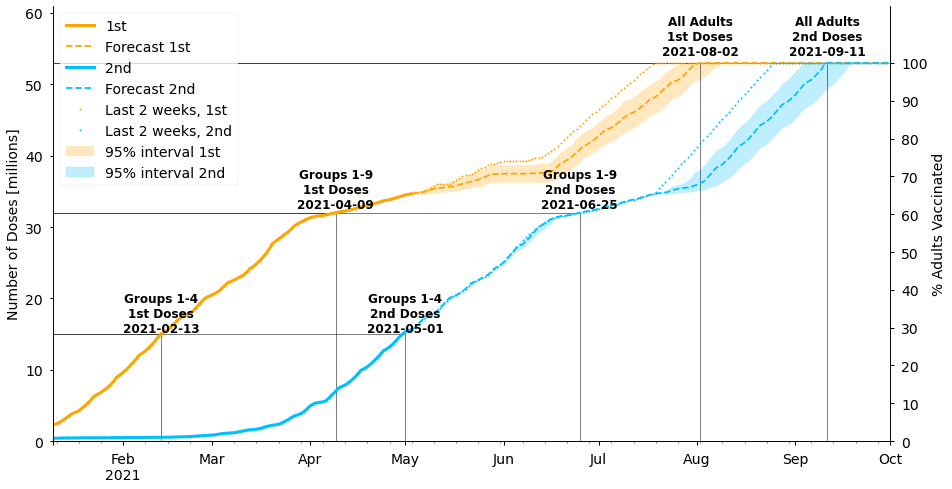

In [32]:
ax = plot_cumulative_doses(
    pd.DataFrame(
        {
            "cumFirst": q_forecasts["cumFirst"].loc[0.5],
            "cumSecond": q_forecasts["cumSecond"].loc[0.5],
        }
    ),
    forecast_date=last_data,
    figsize=(15, 8),
)

q_start = 0.025
q_end = 0.975
alpha = 0.25
for col in ["cumFirst", "cumSecond"]:
    # add shaded region between q_start and q_end quantiles
    ax.fill_between(
        q_forecasts[col].loc[q_start].index,
        q_forecasts[col].loc[q_start],
        q_forecasts[col].loc[q_end],
        color=col_format[col]["color"],
        alpha=alpha,
        label=f"95% interval {col_format[col]['label']}",
    )
    # also show previous (last week average) forecast, to compare
    df_forecast[col].plot(
        linestyle="None",
        marker=".",
        markersize=4,
        color=col_format[col]["color"],
        label=f"Last 2 weeks, {col_format[col]['label']}",
        ax=ax,
    )

ax.legend()

Under these assumptions, the population is fully vaccinated with two doses a couple of weeks later in mid-September rather than late-August. Note that our original forecast using the rate from the last 2 weeks lies outside of the uncertainty band for our new forecast. In other words, the population will only be vaccinated by the end of August if vaccines continue to be given at their current high rate without reverting back to the lower rates seen earlier in the year.

If we implemented a more sophisticated forecasting algorithm, such as an [autoregressive](https://en.wikipedia.org/wiki/Autoregressive_model) or [Bayesian structural time series](https://minimizeregret.com/post/2020/06/07/rediscovering-bayesian-structural-time-series/) model, we may be able to get improved estimates that incorporate the likelihood of both our "optimistic" and "pessimistic" cases.

## Government Targets and SAGE Vaccine Roll-out Estimates

The government has the target of all UK adults being [offered a first dose of the vaccine by the end of July](https://www.bbc.co.uk/news/uk-56141867). This is roughly in line with both of our forecasting approaches, with our optimistic forecast being a bit earlier in mid-July and the pessimistic forecast early-August. At the end of March, the Scientific Advisory Group for Emergencies (SAGE) also [produced a report](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/975909/S1182_SPI-M-O_Summary_of_modelling_of_easing_roadmap_step_2_restrictions.pdf) including the following two scenarios for the vaccine roll-out in England:
- **Fast scenario:** 0.39m doses per day in England until week commencing 26th July and 0.29m per day thereafter
- **Slow scenario:** 0.36m doses per day in England until week commencing 26th July and 0.29m per day thereafter

Approximately scaling these up for the whole UK (56 million population England, 67 million population UK) gives:
- **Fast scenario:** 0.46m doses per day until week commencing 26th July and 0.34m per day thereafter
- **Slow scenario:** 0.43m doses per day until week commencing 26th July and 0.34m per day thereafter

The SAGE forecasts use an 11-week (77 day) period between doses, which is also in line with what we derived ourselves from the data.

We can implement the assumptions from SAGE ourselves in our own forecasts just by creating a new `doses_fn` (`sage_doses` below) that returns a fixed number of doses depending on whether we're using the fast or slow strategy, and whether the date is after the 26th July or not:

In [33]:
def forecast_sage(
    df,
    avg_second_delay=77,
    scenario="fast",
    uk_pop=priority_totals["All Adults"],
    end_date=datetime(2021, 10, 1),
    min_second_delay=77,
):
    """
    Forecast vaccines for the SAGE 'fast' and 'slow' scenarios.
    """
    if not (scenario == "fast" or scenario == "slow"):
        raise ValueError("scenario must be 'fast' or 'slow'")

    def sage_doses(df, date, scenario=scenario):
        if date > datetime(2021, 7, 25):
            return 0.34
        else:
            if scenario == "fast":
                return 0.46
            else:
                return 0.43

    df_forecast = forecast_vaccines(
        df,
        avg_second_delay,
        doses_fn=sage_doses,
        uk_pop=uk_pop,
        end_date=end_date,
        min_second_delay=min_second_delay,
    )

    return df_forecast

Then we can generate and plot the forecasts in the same way as we've done before (displaying both the fast and slow strategies in the same figure):

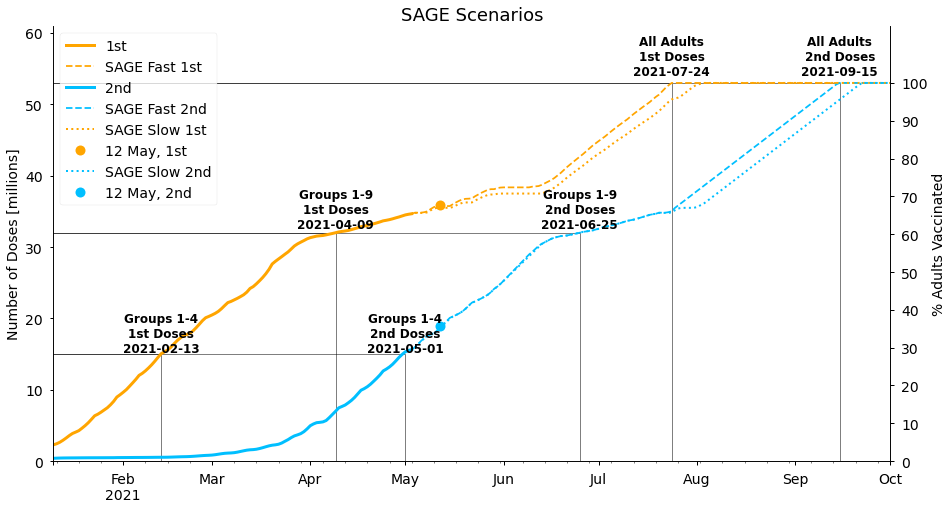

In [34]:
df_sage_fast = forecast_sage(
    df,
    scenario="fast",
)
df_sage_slow = forecast_sage(
    df,
    scenario="slow",
)

ax = plot_cumulative_doses(
    df_sage_fast,
    forecast_date=last_data,
    figsize=(15, 8),
    title=f"SAGE Scenarios",
    forecast_label="SAGE Fast",
)

for col in ["cumFirst", "cumSecond"]:
    ax.plot(
        df_sage_slow.loc[df_sage_slow.index > last_data, col],
        color=col_format[col]["color"],
        linestyle=":",
        linewidth=2,
        label=f"SAGE Slow {col_format[col]['label']}",
    )
    ax.plot(
        publish_date,
        publish_date_data[col],
        "o",
        color=col_format[col]["color"],
        markersize=10,
        label=f"{publish_date.strftime('%d %b')}, {col_format[col]['label']}",
    )

ax.legend()

The SAGE forecasts are similar to our more pessimistic forecasts, with the population fully vaccinated in mid-September, though the difference between their "slow" and "fast" strategies is smaller than the uncertainty we calculated. This gives us confidence that our forecasting approaches are reasonable, though it's interesting that SAGE does not expect the current rate of vaccinations to be maintained. It may be that they are aware of upcoming difficulties in vaccine supplies, or simply that taking a cautious approach is more appropriate for their purposes.

We've also included markers in the figure above that show the current status on 12th May, the time of publication. The actual values look similar to our forecast values, but there have actually been more total doses (first and second combined) overall than we predicted, with 4.5 million doses since the 4th May. In comparison, our optimistic forecast using the average doses in the 2 weeks leading up to 4th May predicted 4.4 million doses, or 3.9 million in our pessimistic forecast using the average rate from the whole year so far (the SAGE scenarios are 3.9 million and 4.1 million). We look forward to seeing how this develops, and plan to do a story in the future to evaluate how well our forecasts performed!

## Conclusion

In this Turing Data Story, we have used data collected from the UK government's Covid-19 data dashboard (using their API) to estimate when the UK may finish fully vaccinating its adult population.

With the demands and challenges of worldwide vaccine supply, it's difficult to accurately estimate how many vaccine doses will be available in the future, so we generated two sets of forecasts - a more optimistic forecast assuming that vaccines will continue to be given at an average of 0.49 million doses per day, which was the rate in the two weeks up to the 4th of May, and a more pessimistic forecast assuming vaccines are given at a rate consistent with the whole year so far. In our optimistic forecast the population is fully vaccinated on 26th August, or in our pessimistic forecasts a few weeks later in mid-September. Our pessimistic forecast is broadly in agreement with the assumptions in modelling by SAGE and with government targets.

As well as the uncertainty in future vaccine supply and demand, our forecasts made a number of simple assumptions about the vaccine roll-out which may not prove to be correct. We assumed 100% of the adult population will be vaccinated, for example, but we know take up rates are lower in certain sub-groups and it may be that take up will also be lower in younger people who are less at risk. In addition, we've assumed second doses will continue to be given 11-weeks after first doses, and haven't considered differences between current and new vaccine types (which may have different dosing regimens) or regional differences. Finally, our forecasts assume constant vaccination rates, but a model incorporating the possibility of upward or downward trends may be more accurate. All these combined mean the range of feasible completion dates is wider than we've calculated.

Nevertheless, we can be hopeful that the majority of the population will be vaccinated by early autumn, and that life in the UK will be much less impacted by Covid-19 on a daily basis by that time, though it's difficult to say whether it will return back to what was considered to be "normal" before 2020! Finishing by the autumn would also be perfect timing for the [anticipated start of giving further booster doses](https://www.bmj.com/content/373/bmj.n1116) to the most vulnerable in time for winter.

Worldwide, Covid-19 case rates are sadly still high and vaccination rates low in many countries at the time of writing. This [excellent dashboard from Our World in Data](https://ourworldindata.org/covid-vaccinations#source-information-country-by-country) shows vaccination progress worldwide, including links to data sources that (with some pre-processing) could also be fed into the forecasting functions developed here. For European countries, the European Centre for Disease Prevention and Control has [a combined dataset available](https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea). Do feel free to experiment with the code from this story; ideas could include looking at the forecast results for different dates in the past (by changing `run_as_date`), using data from other countries, or trying different forecasting algorithms, for example. Thanks for reading!